In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))

from change_of_parameters import omega_CDM_to_luisa

from scipy.constants import c as c_light #meters/seconds
c_light_km = c_light/1000 #km/s

from getdist import plots
import getdist
from getdist import plots, MCSamples, loadMCSamples
getdist.chains.print_load_details = False
import scipy
from scipy.integrate import simps,solve_ivp
from scipy.linalg import sqrtm
import numpy as np

from seaborn import heatmap
import pandas as pd
import emcee

import time


def F_H(H, params, model):     
    lamb, L, beta, L_bar = params
    if model == 'GILA':
        FH = H**2 \
           + H**8 * L**6     * lamb * np.exp(lamb*(L*H)**2) \
           - H**6 * L_bar**4 * beta * np.exp(-beta*(L_bar*H)**10)
    
    elif model == 'BETA':
        FH = H**2 \
            + H**8 * L**6 * lamb * np.exp(lamb*(L*H)**4) \
            - H**2        * beta * np.exp(-beta*(L_bar*H)**8) 

    return FH

In [2]:
def F_H_prime(H, params, model):
    lamb, L, beta, L_bar = params

    if model == 'GILA':
        aux = np.exp(-beta*(L_bar*H)**10) * beta * (L_bar*H)**4 * (-3 + 5 * beta * (L_bar*H)**10) +\
                np.exp(lamb*(L*H)**2) * lamb * (L*H)**6 * (4 + lamb*(L*H)**2)
    if model == 'BETA':
        aux = np.exp(-beta*(L_bar*H)**8)  * beta                * (-1 + 4 * beta * (L_bar*H)**8) +\
            2 * np.exp(lamb*(L*H)**4) * lamb * (L*H)**6 * (2 + lamb*(L*H)**4)

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime

In [3]:
def get_odes(log_a, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    #kappa = 8 * np.pi * G_newton / 3
    kappa = 1

    [lamb, L, b, L_bar, H_0, model] = params_ode

    F_H0 = F_H(H_0, [lamb, L, b, L_bar], model)

    omega_r_0 = 2.47e-5
    omega_m_0 = F_H0 /(100**2) - omega_r_0

    rho_m_0 = 100**2 * omega_m_0 / kappa
    rho_r_0 = 100**2 * omega_r_0 / kappa
    
    #a = 1/(1+z)
    #a = int(10**log_a)

    #a**(-4) = 10**(-4*log_a)
    #a**(-3) = 10**(-3*log_a)
    #a = np.power(10, log_a)

    rho_r = rho_r_0 * np.power(10, -4*log_a)
    rho_m = rho_m_0 * np.power(10, -3*log_a)
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    #s =  3 * kappa * (rho_tot + p_tot/c_light_km**2) / ((1+z) * F_H_prime(Hubble, [lamb, L, b, L_bar],model))
    # To integrate in a
    #s =  - 3 * kappa * (rho_tot + p_tot/c_light_km**2) / (a * F_H_prime(Hubble, [lamb, L, b, L_bar],model))     
    # To integrate in log(a)
    s =  - 3 * kappa * (rho_tot + p_tot/c_light_km**2) / (F_H_prime(Hubble, [lamb, L, b, L_bar],model))     

    #print(s)
    return s


def integrator_GILA_log(physical_params, model, num_log_a_points=int(10e5),
                initial_log_a=-70, final_log_a=-2,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    
    L_bar, b, H0 = physical_params
    log_a_int = np.linspace(initial_log_a, final_log_a, num_log_a_points)
    ode_params = [0, 1e-27/H0, b, L_bar/H0, H0, model]
    sol = solve_ivp(system_equations, (initial_log_a,final_log_a),
                    [H0], t_eval=log_a_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_log_a_points, 'Something is wrong with the integration!'
    assert np.all(log_a_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    log_a_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return log_a_final, Hs_final

In [4]:
discard=0
thin=1

os.chdir(path_data)
print(path_data)

samples_lcdm = emcee.backends.HDFBackend(os.path.join('sample_LCDM_PPS_CC_3params', 'sample_LCDM_PPS_CC_3params.h5'))
samples_beta = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_BETA_PPS_CC_3params', 'sample_BETA_PPS_CC_3params.h5'))
samples_gila = emcee.backends.HDFBackend(os.path.join('L=0.90','sample_GILA_PPS_CC_3params', 'sample_GILA_PPS_CC_3params.h5'))

#nwalkers, ndim = reader_lcdm.shape #Number of walkers and parameters
flat_samples_beta = samples_beta.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_gila = samples_gila.get_chain(discard=discard, flat=True, thin=thin)
flat_samples_lcdm = samples_lcdm.get_chain(discard=discard, flat=True, thin=thin)

/home/matias/Documents/Repos/GILA-output/paper


In [5]:
#plt.plot(flat_samples_gila[:,2])
#print(flat_samples_beta)
#print(flat_samples_lcdm)

In [6]:
omega_r = 2.47e-5 
L_bar = 0.90

Gyr_to_second = int(3.1536e16)
Mpc_to_km = int(3.0857e19)
inv_Hub_to_Gyr = Mpc_to_km/Gyr_to_second


In [7]:
#LCDM MODEL
#M_abs = flat_samples_lcdm[:,0]
omega_m = flat_samples_lcdm[:,1]
H0 = flat_samples_lcdm[:,2]

Omega_r_lcdm = omega_r / (H0/100)**2
Omega_m_lcdm = omega_m / (H0/100)**2
Omega_L_lcdm = 1 - Omega_m_lcdm - Omega_r_lcdm
aou_lcdm = np.zeros(len(H0))


zs_final = np.logspace(-2, 3, int(10e3))
def aou_lcdm_calc(z, H0, Omega_r_lcdm, Omega_m_lcdm, Omega_L_lcdm):
    Hubble = H0 * np.sqrt(Omega_r_lcdm * (1+z)**4 + Omega_m_lcdm * (1+z)**3 + Omega_L_lcdm )
    return inv_Hub_to_Gyr * simps(((1+z) * Hubble)**(-1), z) 

for i in range(len(aou_lcdm)):
    aou_lcdm[i] = aou_lcdm_calc(zs_final, H0[i], Omega_r_lcdm[i], Omega_m_lcdm[i], Omega_L_lcdm[i])

In [8]:
#BETA MODEL
#M_abs = flat_samples_beta[:,0]
beta = flat_samples_beta[:,1]
H0 = flat_samples_beta[:,2]

aou_beta = np.zeros(100)

for i in range(len(aou_beta)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        log_a_final, Hs_final = integrator_GILA_log(physical_params,model='BETA', num_log_a_points=int(10e4),
                                            initial_log_a=-3, final_log_a=0) #3 para z=1000
        aou_beta[i] = inv_Hub_to_Gyr * simps((Hs_final)**(-1), log_a_final)    
    except Exception as e:
        # If integration fails, reject the step
        aou_beta[i] = 0

In [16]:
#GILA MODEL
#M_abs = flat_samples_gila[:,0]
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]

aou_gila = np.zeros(500)

for i in range(len(aou_gila)):
    physical_params =  [L_bar, beta[i], H0[i]] 
    try:
        log_a_final, Hs_final = integrator_GILA_log(physical_params,model='GILA', num_log_a_points=int(10e4),
                                            initial_log_a=-3, final_log_a=0) #3 para z=1000
        aou_gila[i] =  inv_Hub_to_Gyr * simps((Hs_final)**(-1), log_a_final)
        print(log_a_final)
    except Exception as e:
        # If integration fails, reject the step
        aou_gila[i] = 0

    

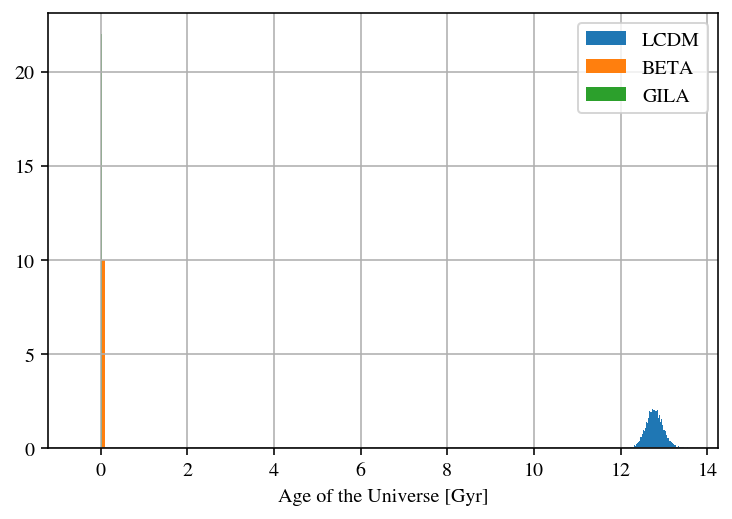

In [14]:
plt.figure()
plt.grid()
plt.hist(aou_lcdm, bins=int(np.sqrt(len(aou_lcdm))), density=True, alpha=1)
plt.hist(aou_beta, bins=int(np.sqrt(len(aou_beta))), density=True, alpha=1)
plt.hist(aou_gila, bins=int(np.sqrt(len(aou_gila))), density=True, alpha=1)
plt.legend(['LCDM','BETA','GILA'])
plt.xlabel('Age of the Universe [Gyr]')

os.chdir(path_figures)
plt.savefig('AOU_{}.pdf'.format(L_bar))

In [ ]:
aou_gila

Integrate to z=1000

In [ ]:
plt.hist(aou_gila)
mask_up = np.where(aou_gila>50)[0]
mask_down = np.where(aou_gila<50)[0]

In [ ]:
H0_down = flat_samples_gila[:,2][mask_down]
H0_up = flat_samples_gila[:,2][mask_up]

plt.hist(H0_down)
plt.hist(H0_up)

In [ ]:
#beta = flat_samples_gila[:,1][mask_down]
beta_down = flat_samples_gila[:,1][mask_down]
beta_up = flat_samples_gila[:,1][mask_up]

plt.hist(beta_down)
plt.hist(beta_up)

In [ ]:
beta = flat_samples_gila[:,1]
H0 = flat_samples_gila[:,2]

beta_down = flat_samples_gila[:,1][mask_down]
H0_down = flat_samples_gila[:,2][mask_down]

beta_up = flat_samples_gila[:,1][mask_up]
H0_up = flat_samples_gila[:,2][mask_up]

# Create MCSamples object
samples = MCSamples(samples=np.c_[H0, beta], names=['H0', 'beta'], labels=['H_0', r'\beta'])
samples_down = MCSamples(samples=np.c_[H0_down, beta_down], names=['H0', 'beta'], labels=['H_0', r'\beta'])
samples_up = MCSamples(samples=np.c_[H0_up, beta_up], names=['H0', 'beta'], labels=['H_0', r'\beta'])

# Generate the 2D plot
g = plots.get_subplot_plotter()
g.triangle_plot(samples, ['H0', 'beta'], filled=True)
g.triangle_plot([samples_down, samples_up], ['H0', 'beta'], filled=True, legend_labels=['Bad', 'Good'])


In [ ]:
#GILA MODEL
beta = flat_samples_gila[:,1][mask_down]
H0 = flat_samples_gila[:,2][mask_down]

#beta = flat_samples_gila[:,1]
#H0 = flat_samples_gila[:,2]

#aou_gila = np.zeros(500)

#for i in range(len(aou_gila)):
i=0
physical_params =  [L_bar, beta[i], H0[i]] 
zs_final, Hs_final = integrator_GILA_log(physical_params,model='GILA', num_z_points=int(10e4),
                                        initial_z=np.log10(0.01), final_z=70)
plt.plot(zs_final, Hs_final)
plt.xlabel('log(z)')
print(zs_final, Hs_final)